<a href="https://colab.research.google.com/github/gitamgadtaula/F_S_E_C/blob/fsec/Masters_thesis_1_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
raw_data=pd.read_csv("/content/drive/MyDrive/thesis dataset/ntc_raw_data.csv")
# Converting Timestamp into date format
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'],unit='s',origin='unix')
raw_data['Date'] = raw_data['Timestamp'].dt.date
raw_data = raw_data.drop(columns=['Timestamp'])
raw_data.head()


,Close,Open,High,Low,Volume,Date
0,355.83,351.67,358.33,354.17,540.0,2012-01-01
1,363.33,355.83,363.33,350.00,1266.0,2012-01-02
2,362.50,363.33,362.50,358.33,1524.0,2012-01-03
3,354.17,362.50,364.17,354.17,2424.0,2012-01-04
4,362.50,354.17,362.50,350.00,1248.0,2012-01-05


In [60]:
# Simple Moving Average


def SMA(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()

# Exponential Moving Average
def EMA(data, period=30, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

# Moving Average Convergence Divergence
def MACD(data, period_short=12, period_long=26, column='Close'):
    EMA_short = EMA(data, period_short, column)
    EMA_long = EMA(data, period_long, column)
    MACD_line = EMA_short - EMA_long
    signal_line = MACD_line.ewm(span=9, adjust=False).mean()
    return MACD_line, signal_line

# Relative Strength Index
def RSI(data, period=14, column='Close'):
    delta = data[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    average_gain = up.rolling(window=period).mean()
    average_loss = abs(down.rolling(window=period).mean())
    rs = average_gain / average_loss
    return 100 - (100 / (1 + rs))

# Bollinger Bands
def Bollinger_Bands(data, period=30, column='Close'):
    SMA = data[column].rolling(window=period).mean()
    std_dev = data[column].rolling(window=period).std()
    upper_band = SMA + (2 * std_dev)
    lower_band = SMA - (2 * std_dev)
    return upper_band, lower_band

# Stochastic Oscillator
def Stochastic_Oscillator(data, period=14):
    high = data['High'].rolling(window=period).max()
    low = data['Low'].rolling(window=period).min()
    close = data['Close']
    return 100 * ((close - low) / (high - low))

# On Balance Volume
def OBV(data, column='Close'):
    volume = data['Volume']
    change = data[column].diff()
    up, down = change.copy(), change.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    return (volume * (up - down)).cumsum()

raw_data['SMA'] = SMA(raw_data)
raw_data['EMA'] = EMA(raw_data)

MACD_line, signal_line = MACD(raw_data)
raw_data['MACD'] = MACD_line
raw_data['Signal Line'] = signal_line

raw_data['RSI'] = RSI(raw_data)
raw_data['Upper Band'], raw_data['Lower Band'] = Bollinger_Bands(raw_data)
raw_data['Stochastic Oscillator'] = Stochastic_Oscillator(raw_data)
raw_data['OBV'] = OBV(raw_data)

raw_data.dropna(inplace=True)

raw_data.head()

,Close,Open,High,Low,Volume,Date,SMA,EMA,MACD,Signal Line,RSI,Upper Band,Lower Band,Stochastic Oscillator,OBV
29,363.33,362.50,364.17,362.50,5880.0,2012-02-15,363.137667,362.154554,0.309510,0.695061,50.000000,371.109326,355.166007,62.462462,143287.14
30,367.50,363.33,367.50,365.00,1026.0,2012-02-16,363.526667,362.499422,0.669872,0.690023,61.907481,371.154263,355.899070,100.000000,147565.56
31,367.50,367.50,369.17,367.50,2202.0,2012-02-21,363.665667,362.822040,0.944573,0.740933,61.907481,371.429204,355.902129,83.300000,147565.56
32,370.83,367.50,371.67,370.00,12600.0,2012-02-23,363.943333,363.338682,1.414672,0.875681,67.994242,372.119258,355.767408,93.280000,189523.56
33,370.00,370.83,370.00,366.67,3240.0,2012-02-26,364.471000,363.768445,1.700650,1.040675,60.876369,372.059047,356.882953,86.640000,192212.76


In [61]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import math

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_scale = raw_data[['Close', 'Volume', 'SMA', 'EMA', 'MACD', 'RSI', 'Stochastic Oscillator', 'OBV']]
scaled_data = scaler.fit_transform(data_to_scale)

# Reshape data into format [samples, time steps, features]
X, y = [], []
# 60 as a loockback period
for i in range(60, len(scaled_data)):
   X.append(scaled_data[i-60:i])
   y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
print(len(X[0]),y[0])





60 0.061644491241504784


In [82]:
# Split the data into training and testing sets

aligned_dates = np.array(raw_data['Date'])[60:] # because Given that the lookback period is 60, the first 60 data points of the original dataset won't be included in X and y

X_train, X_test, y_train, y_test,dates_train, dates_test = train_test_split(X, y,aligned_dates,test_size=0.2, random_state=42,shuffle=False)

import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting a single value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/20
82/82 [==============================] - 8s 47ms/step - loss: 0.0061
Epoch 2/20
82/82 [==============================] - 3s 35ms/step - loss: 0.0022
Epoch 3/20
82/82 [==============================] - 4s 43ms/step - loss: 0.0018
Epoch 4/20
82/82 [==============================] - 3s 35ms/step - loss: 0.0017
Epoch 5/20
82/82 [==============================] - 3s 35ms/step - loss: 0.0016
Epoch 6/20
82/82 [==============================] - 3s 35ms/step - loss: 0.0014
Epoch 7/20
82/82 [==============================] - 4s 44ms/step - loss: 0.0014
Epoch 8/20
82/82 [==============================] - 3s 35ms/step - loss: 0.0013
Epoch 9/20
82/82 [==============================] - 3s 34ms/step - loss: 0.0011
Epoch 10/20
82/82 [==============================] - 3s 35ms/step - loss: 0.0011
Epoch 11/20
82/82 [==============================] - 4s 43ms/step - loss: 9.4736e-04
Epoch 12/20
82/82 [==============================] - 3s 35ms/step - loss: 9.9053e-04
Epoch 13/20
82/82 [==========

In [83]:
# Predicting the prices
predicted_prices = model.predict(X_test)

# Inverse transform the predicted values
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], 7))), axis=1))[:,0]

# Inverse transform the original target values
y_test_scaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 7))), axis=1))[:,0]


# Calculate the RMSE
rmse = math.sqrt(mean_squared_error(y_test_scaled, predicted_prices))
print(rmse)


17/17 [==============================] - 1s 10ms/step
35.03568984039835


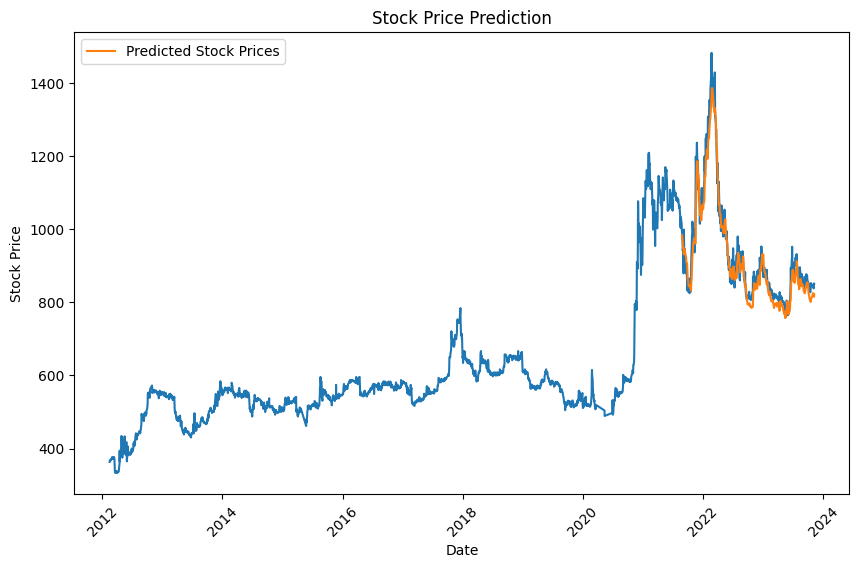

In [88]:

# Plotting the results
plt.figure(figsize=(10,6))
# plt.plot(dates_test, y_test_scaled, label='Actual Stock Prices')
plt.plot(raw_data['Date'],raw_data['Close'])
# plt.plot(dates_test,y_test)
plt.plot(dates_test, predicted_prices, label='Predicted Stock Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)  # Rotating date labels for better readability
plt.legend()
plt.show()